In [1]:
using Graphs, MetaGraphsNext
using Revise
includet("../../utils/visu.jl")
includet("../../utils/graph.jl")
includet("io.jl")

In [2]:
function read_gml_file(file_path::String)
    open(file_path, "r") do file
        return read(file, String)
    end
end

function get_graph_from_gml(path)
    gml_content = read_gml_file(path)

    g = Graph()

    gml_splitted = split(gml_content, '\n')
    i_line = 1
    name = "unknown-network"

    while i_line < length(gml_splitted)
        line = strip(gml_splitted[i_line])

        if startswith(line, "Network ") 
            key, name = split(line, " ")
            name = strip(name, ['"'])
        end


        if startswith(line, "node") 
            add_vertex!(g)
        end

        if startswith(line, "edge")
            i_line += 1
            line = strip(gml_splitted[i_line])
            key, src = split(line, " ")
            i_line += 1
            line = strip(gml_splitted[i_line])
            key, dst = split(line, " ")
            add_edge!(g, parse(Int, src)+1, parse(Int, dst)+1)
        end

        i_line = i_line+1
    end

    return g, name
end

function put_as_substrate_and_save(g)
    mg = MetaGraph(
        Graph(),
        Int,
        Dict,
        Dict,
        Dict(:name=>"s_" * name, :type=>"substrate")
    )

    for node in vertices(g)
        add_vertex!(mg, node, Dict(:cap=> 1, :cost => 0))
    end
    cap_to_put = 1
    random_cap = true
    cap_edge_min=2
    cap_edge_max=4


    for edge in edges(g)
        if random_cap
            cap_to_put = rand(cap_edge_min:3)
        end
        add_edge!(mg, src(edge), dst(edge), Dict(:cap=>cap_to_put, :cost =>1))
    end

    write_network_to_json(mg, false)
end

function put_as_virtual_and_save(g)

    mg = MetaGraph(
        Graph(),
        Int,
        Dict,
        Dict,
        Dict(:name=>"v_" * name, :type=>"virtual")
    )
    
    for node in vertices(g)
        add_vertex!(mg, node, Dict(:dem=> 1))
    end
    for edge in edges(g)
        add_edge!(mg, src(edge), dst(edge), Dict(:dem=>1))
    end

    write_network_to_json(mg, false)
end

put_as_virtual_and_save (generic function with 1 method)

In [3]:
function get_substrate_shortest_path(g)
    mg = MetaGraph(
        Graph(),
        Int,
        Dict,
        Dict,
        Dict(:name=>"s_" * name, :type=>"substrate")
    )

    for node in vertices(g)
        add_vertex!(mg, node, Dict(:cap=> 1, :cost => 0))
    end

    for edge in edges(g)
        add_edge!(mg, src(edge), dst(edge), Dict(:cap=>1, :cost =>1))
    end

    # Get shortest path and increase by 1 the cap everytime the edge is used in a shortest path
    distmx = ones(Int, size(vertices(g), 1), size(vertices(g), 1))
    top_cap = 1
    for i in vertices(g)
        for j in vertices(g)
            if i!=j
                yen_path = yen_k_shortest_paths(mg, i, j, distmx, 1)
                path = yen_path.paths[1]
                for i_node in 1:length(path)-1
                    mg[path[i_node], path[i_node+1]][:cap] = mg[path[i_node], path[i_node+1]][:cap] +1
                    if mg[path[i_node], path[i_node+1]][:cap] > top_cap
                        top_cap = top_cap + 1
                    end
                end
            end
        end
    end

    cap_max = 3
    for edge in edges(mg)
        mg[src(edge), dst(edge)][:cap] = floor(mg[src(edge), dst(edge)][:cap] * cap_max / top_cap - 0.00001) + 1
    end

    write_network_to_json(mg, false)

end

get_substrate_shortest_path (generic function with 1 method)

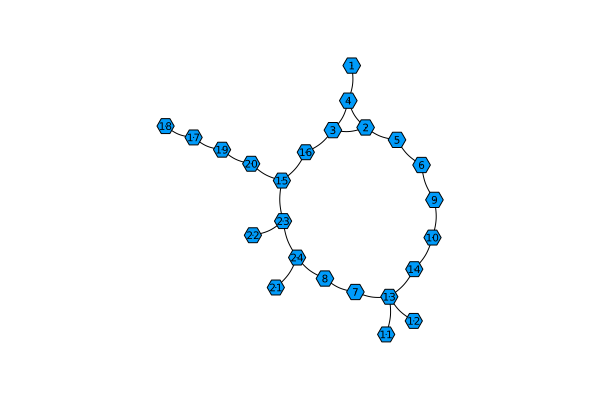

In [15]:
path = "../../../instances/topologyzoo/originals/Psinet.gml"

g, name = get_graph_from_gml(path)

visu_graph(g)

In [69]:
get_substrate_shortest_path(g)

6894

In [14]:
put_as_virtual_and_save(g)

1715